<a href="https://colab.research.google.com/github/salwang323/salwang323.github.io/blob/master/copy_of_spy_predict_next_day_options_feature3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-05  217.800003  221.289993  214.520004  217.610001  217.610001   
2023-06-06  216.139999  221.910004  212.529999  221.309998  221.309998   
2023-06-07  228.000000  230.830002  223.199997  224.570007  224.570007   
2023-06-08  224.220001  235.229996  223.009995  234.860001  234.860001   
2023-06-09  249.070007  252.419998  242.020004  244.595001  244.595001   

               Volume  PriceTimeVolume     VWAP_C  ATR  MA5  OBV  CCI  RSI  
Date                                                                        
2023-06-05  151143100     3.289025e+10  69.667961    1    1    5    5    5  
2023-06-06  146911600     3.251301e+10  69.739489    1    1    5    5    5  
2023-06-07  185710800     4.170508e+10  69.831753    1    1    5    5    5  
2023-06-08  160069700     3

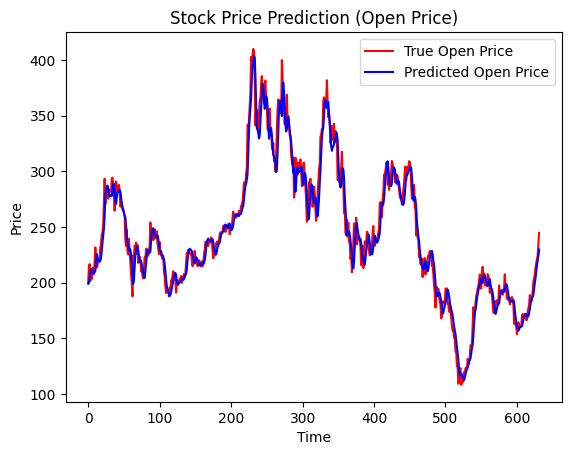

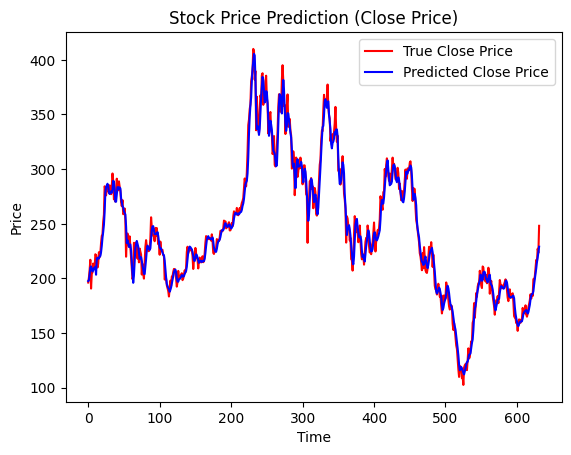

In [ ]:
from yfinance.utils import retreive_financial_details
from tensorflow.python.ops.gen_array_ops import reshape
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas_datareader.data as pdr
import datetime as dt
from keras.optimizers import Adam
from keras.initializers import RandomUniform 

def get_ATR(df):
  return 1

def get_MA5(df):
  return 1

def get_CCI(df):
  return 5

def get_OBV(df):
  return 5

def get_RSI(df):
  return 5
  
seed_value = 42
tf.random.set_seed(seed_value)
features = 3

start_date = dt.datetime(1999, 1, 1)
end_date = dt.datetime.now()
#end_date = dt.datetime(2023, 6, 4)
symbol = 'tsla'  # Replace with the ticker symbol of the stock you want to fetch data for
df = yf.download(symbol, start=start_date, end=end_date)

df['PriceTimeVolume'] = df['Close'] * df['Volume']
df['VWAP_C'] = df['PriceTimeVolume'].cumsum() / df['Volume'].cumsum()

df['ATR'] = get_ATR(df)
df['MA5'] = get_MA5(df)
df['OBV'] = get_OBV(df)
df['CCI'] = get_CCI(df)
df['RSI'] = get_RSI(df)

c = df["Open"].values.reshape(-1,1)
o = df["Close"].values.reshape(-1,1)
v = df["Volume"].values.reshape(-1,1)


d_r = []
for i in range(1, len(c)):
  ret_v = (c[i] - c[i-1])/c[i-1]
  d_r.append(ret_v)

print(df.tail())
#print(d_r)

# 归一化处理
scaler0 = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler_all = MinMaxScaler()

volatility = np.sqrt(252) * np.array(d_r, dtype = float).std()

print ("volatility = ", volatility)

s_o = scaler0.fit_transform(o)
s_c = scaler1.fit_transform(c)
s_v = scaler2.fit_transform(v)
scaler_data = scaler_all.fit_transform(df['Close'].values.reshape(-1, 1))

#print (v)
#print(s_v)

df = np.concatenate((s_o, s_c, s_v), axis = 1)
#df = np.concatenate((s_c, s_v), axis = 1)
print(df)

# 划分训练集和测试集
train_size = int(len(df) * 1)
print("train_size", train_size)
train_data = df[:train_size+1]

train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

train_size = int(len(df))
train_data = df[:train_size+1]

# 定义时间窗口大小
window_size = 20

# 创建训练集和测试集数据
def create_dataset(data, window_size):
    X, Y = [], []
    len1 = len(data)
    print("len =", len1)
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size])
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(train_data, window_size)
X_test, Y_test = create_dataset(test_data, window_size)

last_timestep = X_train[-1:]
print("last_timestep= ", last_timestep)
print("Y_train")
print(Y_train[-1:])

# 创建 LSTM 模型
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(window_size, features),kernel_initializer=RandomUniform(seed=seed_value)))
model.add(LSTM(32, activation='relu'))
#model.add(Dense(units=25))
model.add(Dense(features))
#optimizer1 = Adam(learning_rate = 0.001)
model.compile(optimizer = 'adam', loss='mse')
#model.add(Dropout(0.1))

# 训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=256, verbose=0)
optimizer1 = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer1, loss='mse')
model.fit(X_train, Y_train, epochs = 64)

# 预测测试集数据
#predicted = model.predict(X_test)

# 将预测结果反归一化
#predicted = scaler_all.inverse_transform(predicted)
Y_test = scaler_all.inverse_transform(Y_test)

# predict future values
print("future")
future_predictions = []
for i in range(window_size):
#for i in range(1):
#  print("0:last")
#  print("last_timestep", last_timestep)
  shift = last_timestep[0,1:,:]
  print("shift", shift.shape)

  if (i == 0):
    prediction = Y_train[-1:]
  else:
    prediction = model.predict(last_timestep)
  if ( i == 0):
    print("last day", i, " ", i, prediction)
  future_predictions.append(prediction)
#  print("tomorrow few days", i, " ", scaler.inverse_transform(prediction))
  result = np.concatenate((shift, prediction), axis = 0)
#  print("after cat", result.shape)
  last_timestep = np.expand_dims(result, axis=0)
#  print("after dims add", last_timestep.shape)

#print("after for loop, future_predictions")
print(future_predictions)

dim = np.array(future_predictions).reshape(-1, features)
print(dim)
r_dim = np.split(dim, features, axis = 1)
#predictions = scaler.inverse_transform(two_dim)

s_o = r_dim[0]
s_c= r_dim[1]
s_v = r_dim[2]

o= scaler0.inverse_transform(s_o)
c= scaler1.inverse_transform(s_c)
v = scaler2.inverse_transform(s_v)

#print(v)
#print(c)
#print(o)

prediction = np.concatenate((o, c), axis = 1)

print(prediction)

predicted = model.predict(X_test)
predicted = scaler_all.inverse_transform(predicted)


# 可视化预测结果
plt.plot(Y_test[:, 0], color='red', label='True Open Price')
plt.plot(predicted[:, 0], color='blue', label='Predicted Open Price')
plt.title('Stock Price Prediction (Open Price)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.plot(Y_test[:, 1], color='red', label='True Close Price')
plt.plot(predicted[:, 1], color='blue', label='Predicted Close Price')
plt.title('Stock Price Prediction (Close Price)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#!pip install requests_html
import yfinance as yf
import pandas as pd
import sys
import datetime as dt
stock_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'amd', 'cdns', 'blrx', 'intc','riot', 'dis', 'team', 'gld', 'jd', 'rblx', 'adbe', 'crm', 'fslr', 'bac', 'jpm', 'unh', 'cost', 'meta',
              'tgt', 'nvda', 'xom', 'mvrl', 'avgo', 'tsla', 'u', 'snps', 'crsp', 'meta', 'uber', 'schw', 'arkg', 'arkk', 'gs', 'zs', 'enph', 'tsm', 'panw', 'crwd', 'lrcx', 'nflx', 'tgt',
              'tlt', 'uvxy', 'qqq', 'spy', 'iwm', 'yinn', 'ba', 'lmt', 'lulu', 'sbux', 'xpev', 'orcl','shop', 'abnb', 'twtr','mtch', 'docn', 'lyft', 'mdb', 'bynd', 'afrm', 'dish']

#stock_list = ['docn', 'snow', 'ddog', 'lyft', 'mdb', 'zs']
#stock_list = ['intc', 'nvda', 'amd', 'cdns', 'smh', 'snps', 'avgo']
#stock_list = ['aapl', 'meta', 'u', 'pypl', 'sq']
#stock_list = ['crsp', 'ilmn', 'dna', 'pfe']

def calculate_change_threadhold(data):
  av = data['change'].mean()
  std = data['change'].std()
  threadhold = av + std * 3
  return threadhold

def calculate_volume_threadhold(data):
  av = data['volume'].mean()
  std = data['volume'].std() 
  threadhold = av + std * 5
  return threadhold

def isUseful(data, im):
  distance_thread = 10
  date = dt.datetime.strptime(data,"%Y-%m-%d").date()
  curr = dt.datetime.now()
  cdate = curr.date()
  
  d = (date - cdate).days
  if (abs(d) <= 130):
    good = 1
  else:
    good = 0
  return good & im;

def getSymbols(sector, marketCapThread, priceThread):
  stock_symbols = yf.Tickers().tickers_by_sector("Technology")
  print(stock_symbols.symbols)
  for symbol in stock_symbols.symbols:
    stock = yf.Ticker(symbol)
    print(stock)
  return "yhoo"

#with open ('output.txt', 'w') as f:
#  sys.stdout = f

#stock_list = getSymbols("tech", "10_000_000_000", "100")
for stock in stock_list:
  options = yf.Ticker(stock).options

  for expiry in options:
#   print(expiry)
    chain = yf.Ticker(stock).option_chain(expiry)
    for s in range (2):
      callput_list = chain[s]

      thread_hold = calculate_volume_threadhold(callput_list)
      a = thread_hold
      b = calculate_change_threadhold
      
      
      for j in range(len(callput_list)):
        if (callput_list['volume'][j] > a) and isUseful(expiry, callput_list['inTheMoney'][j]): #and (callput_list['change'][j] > b):
          print(callput_list['contractSymbol'][j], "volume:", callput_list['volume'][j], "contractSize:", callput_list['contractSize'][j],
                "change", callput_list['change'][j], "percentChange", callput_list['percentChange'][j])
#          print("Stock:", callput_list)
#          print("Expiry Date:", callput_list['contractSymbol'][j], '  ---  ')
#      print(chain)
      
sys.stdout = sys.__stdout__
print ("end")

GOOGL230915C00120000 volume: 1801.0 contractSize: REGULAR change -3.4799995 percentChange -26.810476
AMZN230616C00115000 volume: 17273.0 contractSize: REGULAR change -4.9700003 percentChange -41.07438
AMZN230616P00150000 volume: 22670.0 contractSize: REGULAR change 5.039999 percentChange 21.492533
AMZN230616P00190000 volume: 21347.0 contractSize: REGULAR change 5.220001 percentChange 8.198525
AMZN230915C00117500 volume: 2121.0 contractSize: REGULAR change -3.9300003 percentChange -26.182547
AMZN230915P00125000 volume: 5247.0 contractSize: REGULAR change 2.6699996 percentChange 39.380524
DIS230616P00110000 volume: 22317.0 contractSize: REGULAR change -0.21999931 percentChange -1.2345641
GLD230616P00190000 volume: 15145.0 contractSize: REGULAR change 1.8800001 percentChange 24.415586
GLD230915P00182000 volume: 3050.0 contractSize: REGULAR change 0.5100002 percentChange 13.246759
JD230616P00042500 volume: 2230.0 contractSize: REGULAR change 0.0 percentChange 0.0
RBLX230609P00040000 volume